In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload

In [2]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

TODO: Fill out background of tic tac toe, what tokens mean what, example games, etc
TODO: List model specs

The model correctly infers that the game ends at token 5, so it's next guess is the end of game token 9

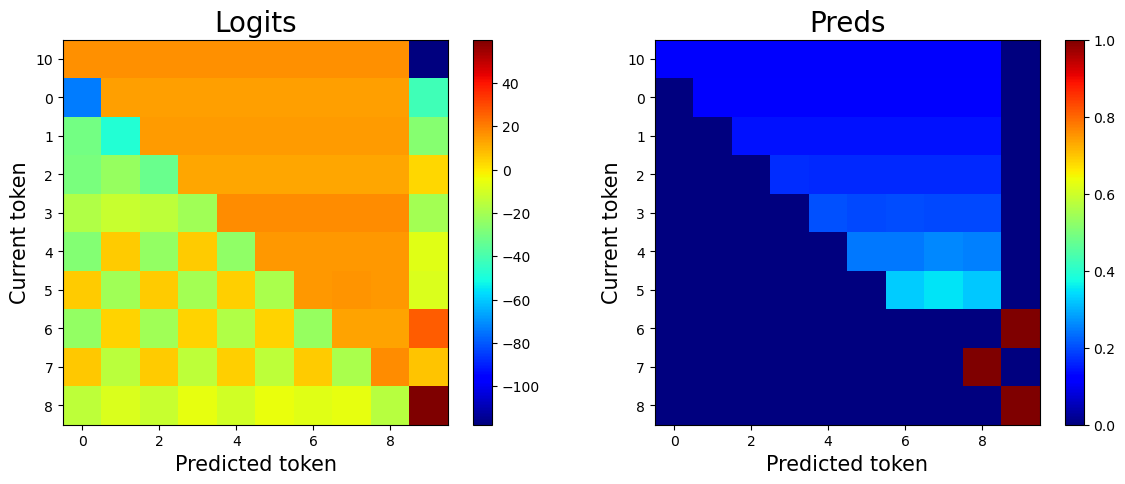

In [3]:
seq_fwd = [10, 0, 1, 2, 3, 4, 5, 6, 7, 8]
interpretability.plot_predictions(
    seq_fwd, model(torch.tensor(seq_fwd, requires_grad=False))
)

In [5]:
def zero_output(module, input, output):
    return torch.zeros_like(output)

By ablating all the attention heads, we can see the model never predicts the token it was passed, even with the attention mechanism ablated.

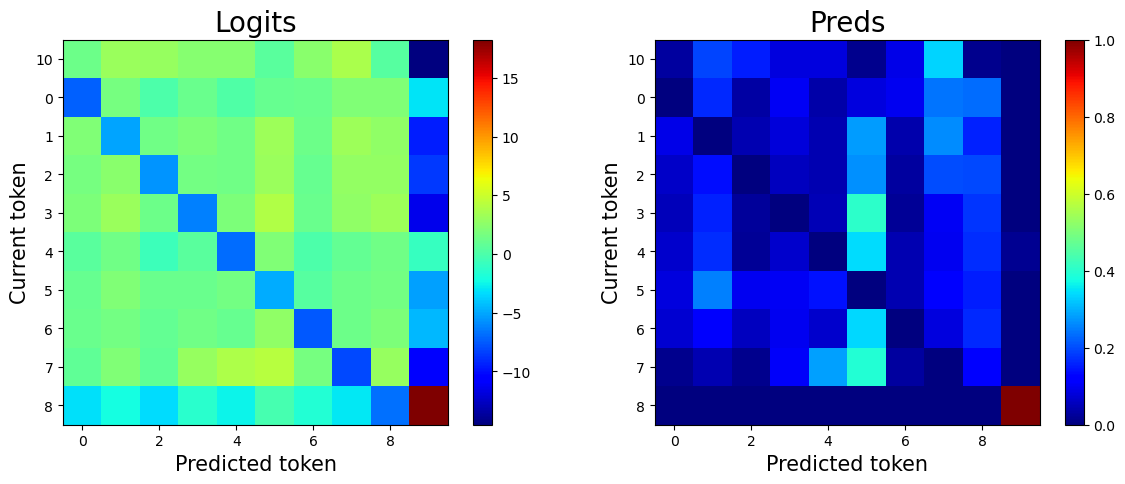

In [10]:
seq_bwd = [10, 8, 7, 6, 5, 4, 3, 2, 1, 0]
handles = []
handles.append(model.blocks[0].attn.register_forward_hook(zero_output))
interpretability.plot_predictions(seq_fwd, model(torch.tensor(seq_fwd)))
[h.remove() for h in handles]
handles = list()

Even with the attention mechanism ablated, we can see the model never predicts the token it was passed.

In [12]:
pos_emb = model.pos_embed(torch.zeros(1, 10), 0)
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
preds_mlp_pos = torch.softmax(logits_mlp_pos, axis=-1)

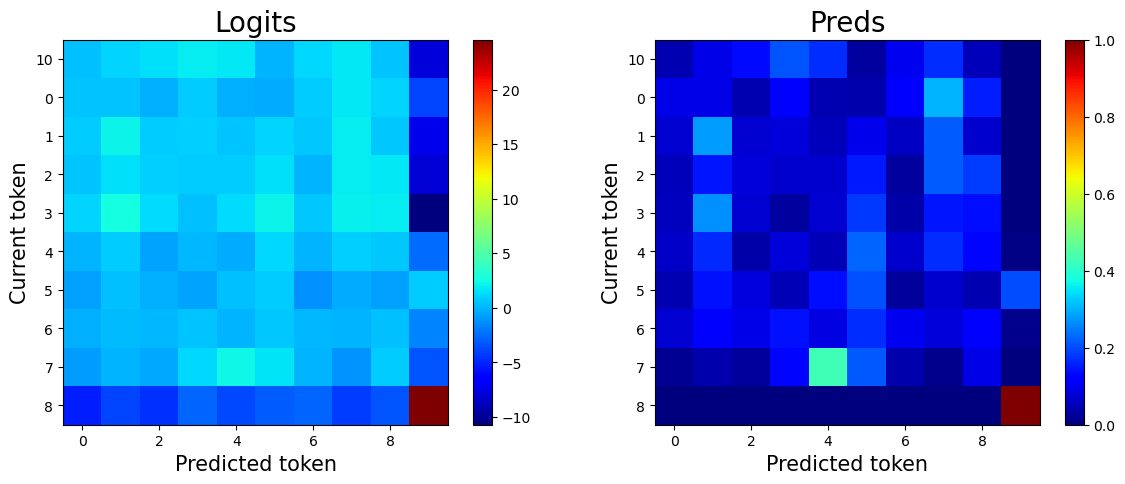

In [14]:
interpretability.plot_predictions(seq_fwd, logits_mlp_pos)

By passing the positional embeddings to the MLP, we can confirm that this combo is responsible for noticing when 9 moves have been played, i.e. the game is over because of a draw

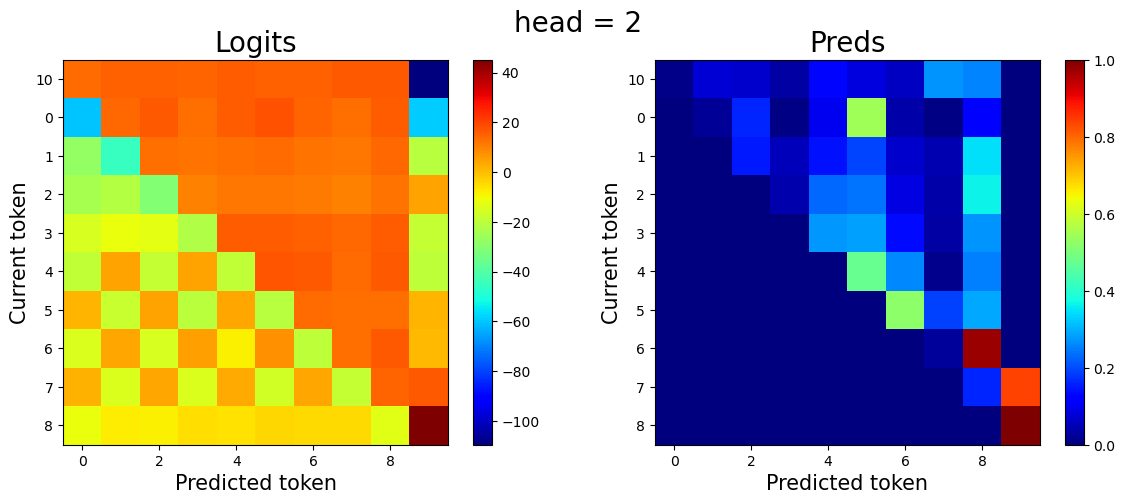

In [21]:
interpretability.plot_predictions(
    seq_fwd, interpretability.ablate_one_head(model, 2, seq_fwd), suptitle="head = 2"
)

Remember, this game should be over when token 6 is played. But when we ablate the output of head 2, we can see that the model no longer believes the game is over when token 6 is played. We can confirm that 2 is the main responsible head by  checking the behavior when ablating the other heads

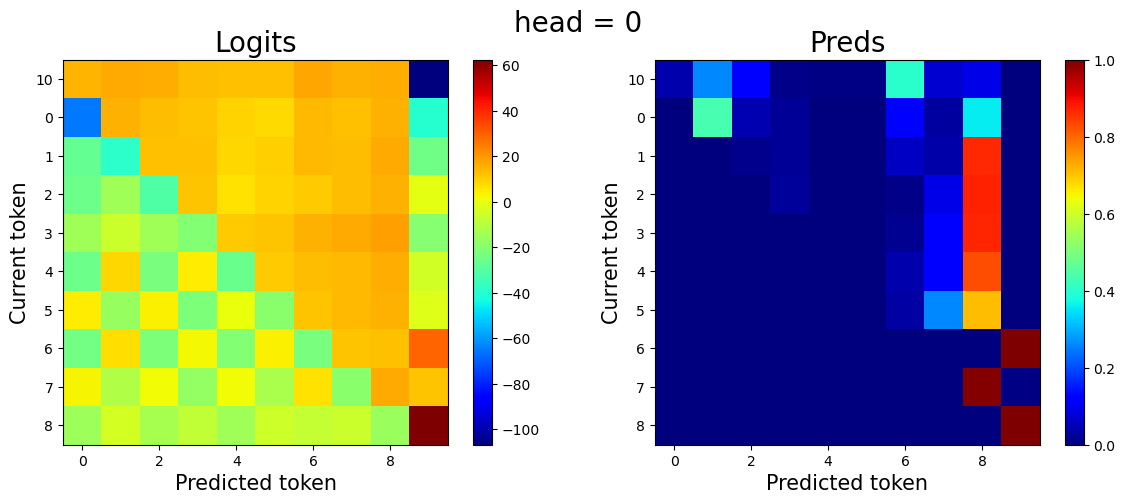

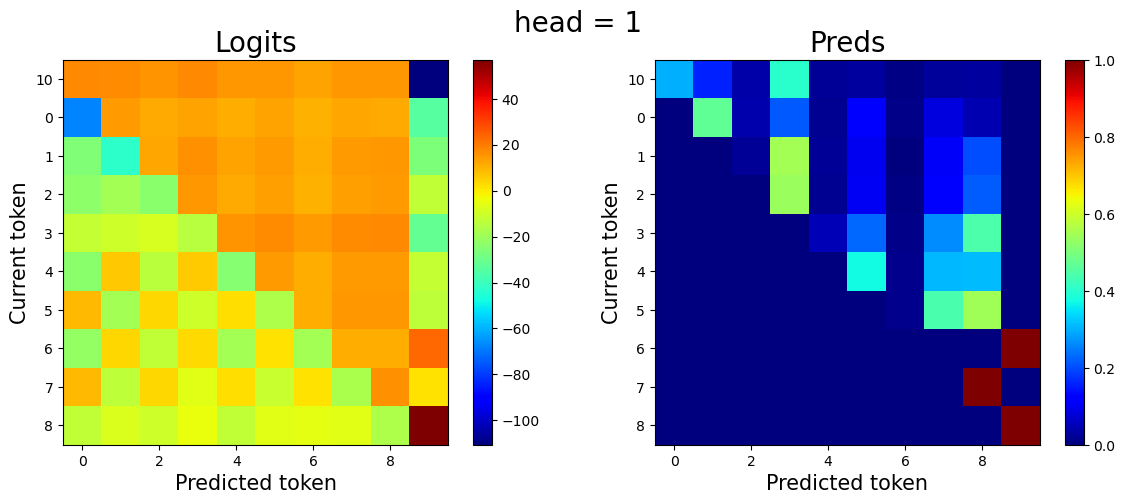

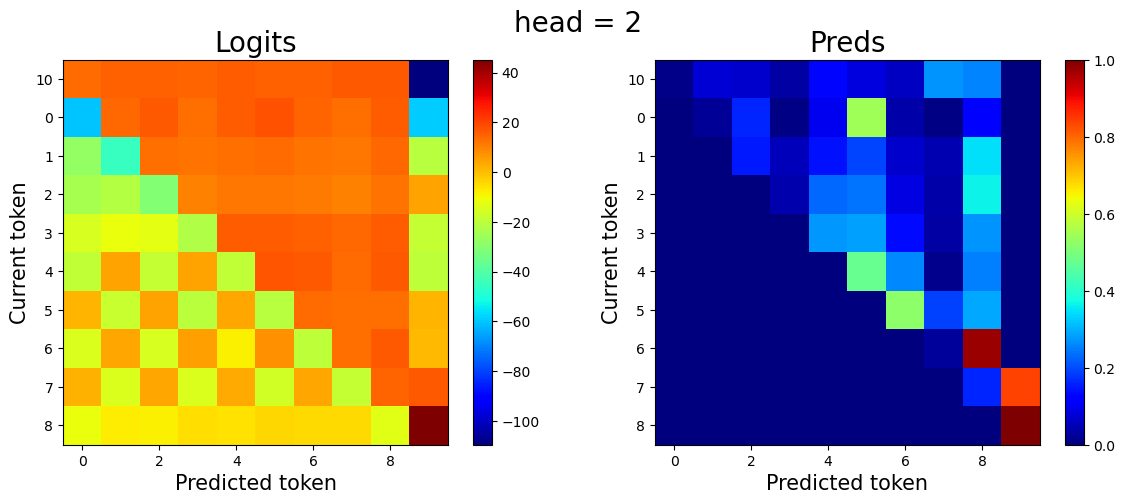

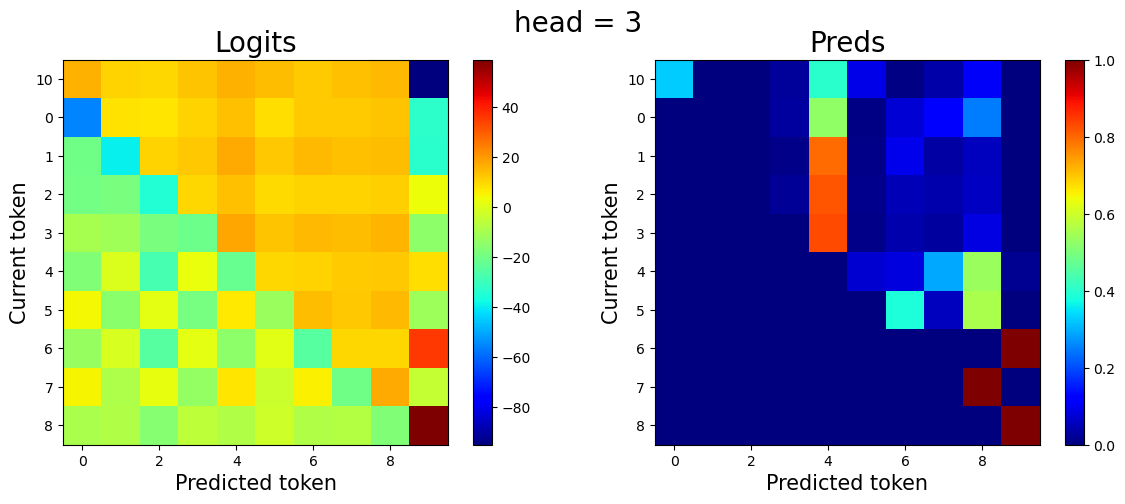

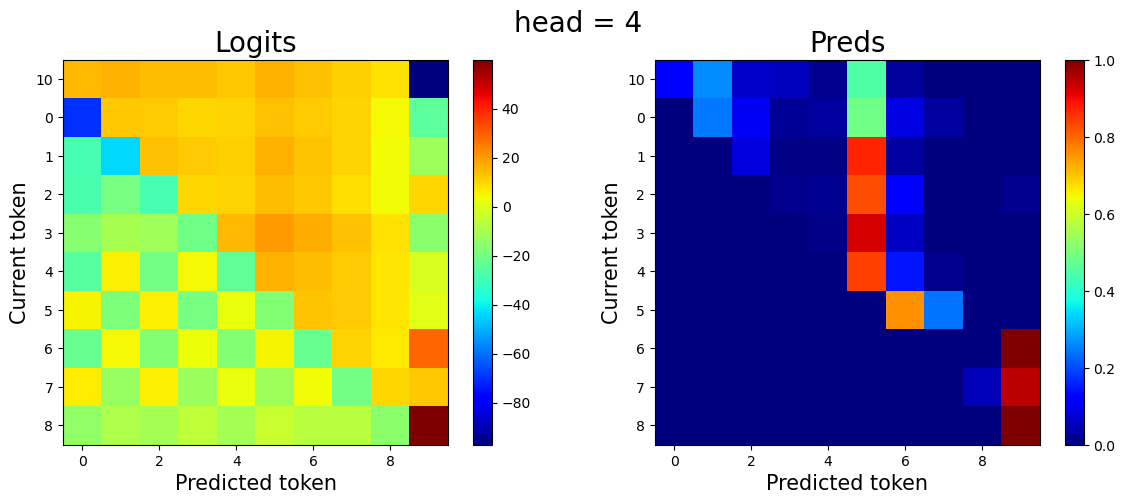

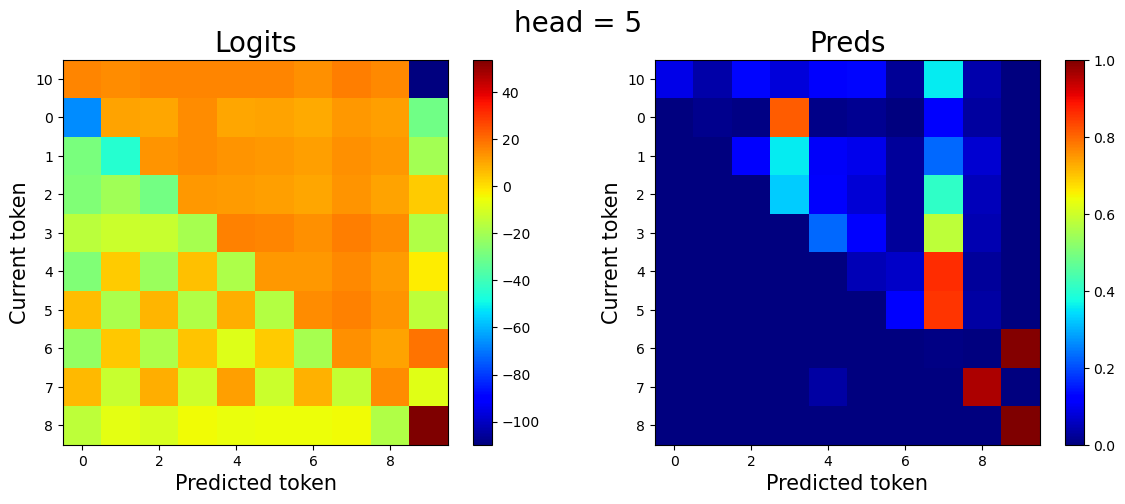

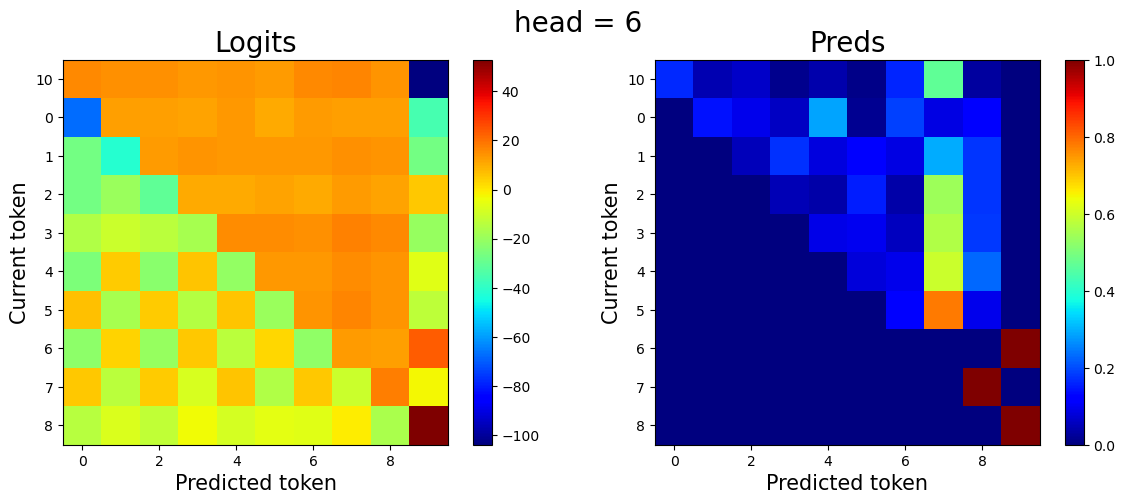

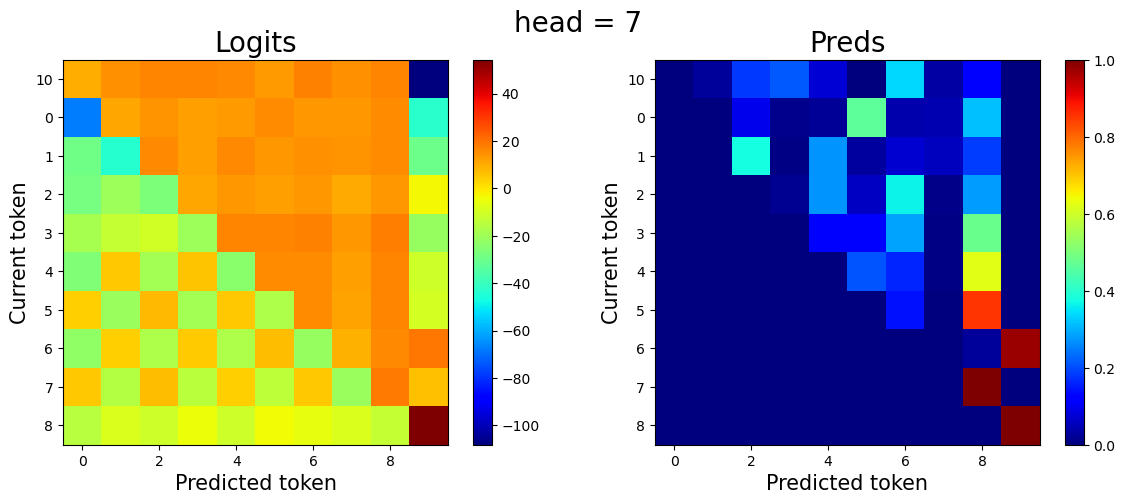

In [22]:
for i in range(8):
    interpretability.plot_predictions(
        seq_fwd, interpretability.ablate_one_head(model, i, seq_fwd), f"head = {i}"
    )

This confirms that head 2 is the most important for determining end state, at least for this particular game. We've also confirmed this behavior across the other end conditions.